In [1]:
import pandas as pd
import numpy as np

In [2]:
base_dir = 'archive(3)/'
df_books = pd.read_csv(base_dir + 'Books.csv', low_memory=False)
df_users = pd.read_csv(base_dir + 'Users.csv', low_memory=False)
df_ratings = pd.read_csv(base_dir + 'Ratings.csv', low_memory=False)

In [3]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
print('No. ratings: ', df_ratings.shape[0])
print('No. users: ', len(set(df_ratings['User-ID'])))
print('No. books: ', len(set(df_ratings['ISBN'])))

No. ratings:  1149780
No. users:  105283
No. books:  340556


### No. NAs

In [7]:
df_books_nas = pd.DataFrame([(~df_books.isnull()).sum(), 
                              df_books.isnull().sum()], index=['no. non-NAs', 'no. NAs']).transpose()
df_books_nas['NA fraction'] = df_books_nas['no. NAs'] / (df_books_nas['no. NAs'] + df_books_nas['no. non-NAs'])

print('df_books')
display(df_books_nas)

df_books


,no. non-NAs,no. NAs,NA fraction
ISBN,271360,0,0.000000
Book-Title,271360,0,0.000000
Book-Author,271359,1,0.000004
Year-Of-Publication,271360,0,0.000000
Publisher,271358,2,0.000007
Image-URL-S,271360,0,0.000000
Image-URL-M,271360,0,0.000000
Image-URL-L,271357,3,0.000011


In [8]:
df_users_nas = pd.DataFrame([(~df_users.isnull()).sum(), 
                              df_users.isnull().sum()], index=['no. non-NAs', 'no. NAs']).transpose()
df_users_nas['NA fraction'] = df_users_nas['no. NAs'] / (df_users_nas['no. NAs'] + df_users_nas['no. non-NAs'])

print('df_users')
display(df_users_nas)

df_users


,no. non-NAs,no. NAs,NA fraction
User-ID,278858,0,0.000000
Location,278858,0,0.000000
Age,168096,110762,0.397199


In [9]:
df_ratings_nas = pd.DataFrame([(~df_ratings.isnull()).sum(), 
                              df_ratings.isnull().sum()], index=['no. non-NAs', 'no. NAs']).transpose()
df_ratings_nas['NA fraction'] = df_ratings_nas['no. NAs'] / (df_ratings_nas['no. NAs'] + df_users_nas['no. non-NAs'])

print('df_ratings')
display(df_ratings_nas)

df_ratings


,no. non-NAs,no. NAs,NA fraction
User-ID,1149780,0,0.0
ISBN,1149780,0,NaN
Book-Rating,1149780,0,NaN


### Rating distribution

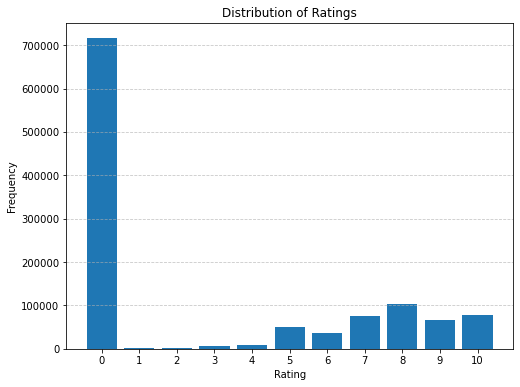

In [10]:
import matplotlib.pyplot as plt

rating_counts = df_ratings['Book-Rating'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(rating_counts.index, rating_counts.values)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(11))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Explicit feedback

### Remove 0-rating from df_ratings and assign to df_implicit

0-rating is associated with implicit user feedback, which is not considered in the current section.

In [11]:
# save implicit ratings for later reference
df_implicit = df_ratings[df_ratings['Book-Rating'] == 0]

df_ratings = df_ratings[df_ratings['Book-Rating'] > 0]

### Model training

Use a down-sampled dataset for models below, as some models take very long time and / or memory to compute.

In [12]:
from surprise import Reader, Dataset, BaselineOnly, KNNBasic, SVD, SVDpp, SlopeOne
from surprise.model_selection import cross_validate

In [13]:
iSel = np.random.choice(range(df_ratings.shape[0]), int(1e4), replace=False)
df_ratings_sampled = df_ratings.iloc[iSel, :].copy()

reader = Reader(rating_scale=(1, 10))
sf = Dataset.load_from_df(df_ratings_sampled, reader)

results = []
modelNames = ['BaselineOnly', 'KNNBasic', 'SVD', 'SVDpp', 'SlopeOne']
for (i, model) in enumerate([BaselineOnly(), KNNBasic(), SVD(), SVDpp(), SlopeOne()]):
    #model.fit(train)
    result = cross_validate(model, sf, measures=["RMSE", "MAE"], cv=5, verbose=False)
    results.append(pd.DataFrame(result).mean(axis=0))
    
display(pd.DataFrame(results, index=modelNames))

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
BaselineOnly,1.784341,1.436962,0.020005,0.006096
KNNBasic,1.839574,1.494589,0.295143,0.008830
SVD,1.771677,1.419034,0.260453,0.006752
SVDpp,1.765362,1.409265,0.762585,0.008339
SlopeOne,1.844212,1.488888,0.615038,0.008161


SVD and SVDpp perform best. However, SVDpp can also consider implicit feedback (such as click actions and other iteractions). The current dataset only contains explicit feedback (user ratings), such that SVDpp might not offer substantial improvements for this dataset. 

### Matrix factorization (SVD) model training on full dataset

Use SVD on full dataset

In [14]:
reader = Reader(rating_scale=(1, 10))
sf = Dataset.load_from_df(df_ratings, reader)

results = []
modelNames = ['SVD']
for (i, model) in enumerate([SVD()]):
    result = cross_validate(model, sf, measures=["RMSE", "MAE"], cv=5, verbose=False)
    results.append(pd.DataFrame(result).mean(axis=0))
    
display(pd.DataFrame(results, index=modelNames))

,test_rmse,test_mae,fit_time,test_time
SVD,1.641659,1.267452,11.563297,0.482409


### Merge user, book, and rating datasets

In [15]:
# create merged dataset
df_merged = df_ratings.merge(df_users, how='left', on='User-ID')
df_merged = df_merged.merge(df_books, how='left', on='ISBN')

# drop rows in case there any other missing values
df_merged.dropna(inplace=True) 

# convert year of publication to numeric
df_merged['Year-Of-Publication'] = pd.to_numeric(df_merged['Year-Of-Publication'])

df_merged.head()

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1,276729,052165615X,3,"rijeka, n/a, croatia",16.0,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
2,276729,0521795028,6,"rijeka, n/a, croatia",16.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
7,276747,0060517794,9,"iowa city, iowa, usa",25.0,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...
8,276747,0671537458,9,"iowa city, iowa, usa",25.0,Waiting to Exhale,Terry McMillan,1995,Pocket,http://images.amazon.com/images/P/0671537458.0...,http://images.amazon.com/images/P/0671537458.0...,http://images.amazon.com/images/P/0671537458.0...
9,276747,0679776818,8,"iowa city, iowa, usa",25.0,Birdsong: A Novel of Love and War,Sebastian Faulks,1997,Vintage Books USA,http://images.amazon.com/images/P/0679776818.0...,http://images.amazon.com/images/P/0679776818.0...,http://images.amazon.com/images/P/0679776818.0...


### Two tower neural network

##### Define Dataset and DataLoader

In [16]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# distinguish user and item features, as well as categorical and continuous features
class BookDataset(Dataset):
    def __init__(self, X_item_cat, X_item_cont, X_user_cat, X_user_cont, y):    
        self.X_item_cat = X_item_cat
        self.X_item_cont = X_item_cont
        self.X_user_cat = X_user_cat
        self.X_user_cont = X_user_cont        
        self.y = y
    
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        x_item_cat = self.X_item_cat[i]        
        x_item_cont = self.X_item_cont[i]   
        x_user_cat = self.X_user_cat[i]        
        x_user_cont = self.X_user_cont[i]            
        y = self.y[i]
        
        return {
            "x_item_cat": torch.tensor(x_item_cat, dtype = torch.long),
            "x_item_cont": torch.tensor(x_item_cont, dtype = torch.float),  
            "x_user_cat": torch.tensor(x_user_cat, dtype = torch.long),
            "x_user_cont": torch.tensor(x_user_cont, dtype = torch.float),               
            "y": torch.tensor(y, dtype = torch.float)
        }

# select continuous and categorical features for items and users
item_cat_features = [
    'ISBN',  
    'Book-Author',
]
item_cont_features = [
    'Year-Of-Publication',
]
user_cont_features = [
    'Age', 
]
user_cat_features = [
    'User-ID',
    'Location',
]

# generate an id for each categorical value
for cat_feature in item_cat_features + user_cat_features:
    le = LabelEncoder()
    le.fit(df_merged[cat_feature])
    df_merged[cat_feature] = le.transform(df_merged[cat_feature])

# continuous feature scaling
for cont_feature in item_cont_features + user_cont_features:
    mn = np.mean(df_merged[cont_feature])
    stddev = np.std(df_merged[cont_feature])
    df_merged[cont_feature] = (df_merged[cont_feature] - mn) / stddev
    
# Split the data into training and testing sets
df_train, df_test = train_test_split(df_merged, test_size=0.2, random_state=42)

# generate training dataset
X_item_cat_train = df_train[item_cat_features].values
X_item_cont_train = df_train[item_cont_features].values
X_user_cat_train = df_train[user_cat_features].values
X_user_cont_train = df_train[user_cont_features].values
y_train = df_train['Book-Rating'].values
y_train = np.reshape(y_train, (-1, 1))
trainDataset = BookDataset(X_item_cat_train, X_item_cont_train, 
                           X_user_cat_train, X_user_cont_train, y_train)

# generate test dataset
X_item_cat_test = df_test[item_cat_features].values
X_item_cont_test = df_test[item_cont_features].values
X_user_cat_test = df_test[user_cat_features].values
X_user_cont_test = df_test[user_cont_features].values
y_test = df_test['Book-Rating'].values
y_test = np.reshape(y_test, (-1, 1))
testDataset = BookDataset(X_item_cat_test, X_item_cont_test, 
                          X_user_cat_test, X_user_cont_test, y_test)

# define dataloaders and batch size
batchSize = 1000
numWorkers = 4
trainDataLoader = DataLoader(trainDataset, batch_size = batchSize, num_workers = numWorkers)
testDataLoader = DataLoader(testDataset, batch_size = batchSize, num_workers = numWorkers)    

##### Define model geometry

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class TwoTowerRecommender(nn.Module):
    def __init__(self, user_emb_szs, item_emb_szs, n_user_cont, n_item_cont, 
                 dropout_prob=0.5):
        super(TwoTowerRecommender, self).__init__()

        self.n_user_cont = n_user_cont
        self.n_item_cont = n_item_cont        
        
        # batch normalization on continuous features
        self.bn_user_cont = nn.BatchNorm1d(n_user_cont)                    
        self.bn_item_cont = nn.BatchNorm1d(n_item_cont)                          
        
        # embedding vectors for categorical features
        self.user_embeds = nn.ModuleList([nn.Embedding(ni, nf) for (ni, nf) in user_emb_szs])
        self.item_embeds = nn.ModuleList([nn.Embedding(ni, nf) for (ni, nf) in item_emb_szs])
        n_user_emb = sum(e.embedding_dim for e in self.user_embeds)
        n_item_emb = sum(e.embedding_dim for e in self.item_embeds)
        self.n_user_emb = n_user_emb
        self.n_item_emb = n_item_emb

        # MLP for user tower, use batch normalization and dropout
        self.user_fc1 = nn.Linear(n_user_emb + n_user_cont, 128)
        self.user_bn1 = nn.BatchNorm1d(128)
        self.user_dropout1 = nn.Dropout(dropout_prob)  
        self.user_fc2 = nn.Linear(128, 64)
        self.user_bn2 = nn.BatchNorm1d(64)
        self.user_dropout2 = nn.Dropout(dropout_prob)  

        # MLP for item tower, use batch normalization and dropout
        self.item_fc1 = nn.Linear(n_item_emb + n_item_cont, 128)
        self.item_bn1 = nn.BatchNorm1d(128)
        self.item_dropout1 = nn.Dropout(dropout_prob)  
        self.item_fc2 = nn.Linear(128, 64)
        self.item_bn2 = nn.BatchNorm1d(64)
        self.item_dropout2 = nn.Dropout(dropout_prob)  
        
        # interaction layer
        self.fc1 = nn.Linear(64 + 64, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_prob)  
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_prob)  
        self.output_layer = nn.Linear(64, 1)        
        
    def forward(self, x_item_cat, x_item_cont, x_user_cat, x_user_cont):        
        
        if self.n_user_emb != 0:
            x_user = [e(x_user_cat[:, i]) for (i, e) in enumerate(self.user_embeds)]           
            x_user = torch.cat(x_user, 1)  
        if self.n_user_cont != 0:  
            x_user_cont = self.bn_user_cont(x_user_cont)            
            x_user = torch.cat([x_user, x_user_cont], 1) if self.n_user_emb != 0 else x_user_cont
    
        if self.n_item_emb != 0:
            x_item = [e(x_item_cat[:, i]) for (i, e) in enumerate(self.item_embeds)]           
            x_item = torch.cat(x_item, 1)  
        if self.n_item_cont != 0:  
            x_item_cont = self.bn_item_cont(x_item_cont)                        
            x_item = torch.cat([x_item, x_item_cont], 1) if self.n_item_emb != 0 else x_item_cont
            
        # user tower
        user_fc1_output = F.relu(self.user_fc1(x_user))
        user_fc1_output = self.user_bn1(user_fc1_output)
        user_fc1_output = self.user_dropout1(user_fc1_output)
        user_fc2_output = F.relu(self.user_fc2(user_fc1_output))         
        user_fc2_output = self.user_bn2(user_fc2_output)
        user_fc2_output = self.user_dropout2(user_fc2_output)
     
        # item tower
        item_fc1_output = F.relu(self.item_fc1(x_item))
        item_fc1_output = self.item_bn1(item_fc1_output)
        item_fc1_output = self.item_dropout1(item_fc1_output)
        item_fc2_output = F.relu(self.item_fc2(item_fc1_output))         
        item_fc2_output = self.item_bn2(item_fc2_output)
        item_fc2_output = self.item_dropout2(item_fc2_output)    

        # concatenate and interaction layer
        concatenated = torch.cat((user_fc2_output, item_fc2_output), dim=1)
        fc1_output = F.relu(self.fc1(concatenated))
        fc1_output = self.bn1(fc1_output)
        fc1_output = self.dropout1(fc1_output)  
        fc2_output = F.relu(self.fc2(fc1_output))
        fc2_output = self.bn2(fc2_output)
        fc2_output = self.dropout2(fc2_output)  
        output = self.output_layer(fc2_output)
        return output    

# use GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)    
    
# determine categorical feature cardinalities for use with embedding vectors
# use embedding vectors of size 50
user_cardins = [len(set(df_merged[cat_feature])) + 1 for cat_feature in user_cat_features]
item_cardins = [len(set(df_merged[cat_feature])) + 1 for cat_feature in item_cat_features]
user_embeddingSizes = len(user_cat_features) * [50]
item_embeddingSizes = len(item_cat_features) * [50]
user_emb_szs = list(zip(user_cardins, user_embeddingSizes))
item_emb_szs = list(zip(item_cardins, item_embeddingSizes))

# determine number of continuous features
n_user_cont = len(user_cont_features)
n_item_cont = len(item_cont_features)

# Initialize the model
model = TwoTowerRecommender(user_emb_szs, item_emb_szs, n_user_cont, n_item_cont, 
                            dropout_prob=0.0)
model = model.to(device)

# Use MSE loss
criterion = nn.MSELoss()

# use Adam optmizer
# weight_decay is for L2 regularization
optimizer = optim.Adam(params=model.parameters(), lr=0.01, weight_decay=0.01)

print(model)

cuda
TwoTowerRecommender(
  (bn_user_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_item_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (user_embeds): ModuleList(
    (0): Embedding(40544, 50)
    (1): Embedding(13254, 50)
  )
  (item_embeds): ModuleList(
    (0): Embedding(119945, 50)
    (1): Embedding(50883, 50)
  )
  (user_fc1): Linear(in_features=101, out_features=128, bias=True)
  (user_bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (user_dropout1): Dropout(p=0.0, inplace=False)
  (user_fc2): Linear(in_features=128, out_features=64, bias=True)
  (user_bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (user_dropout2): Dropout(p=0.0, inplace=False)
  (item_fc1): Linear(in_features=101, out_features=128, bias=True)
  (item_bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (item_dro

##### Set up training loop

In [18]:
from tqdm.notebook import tqdm

nEpochs = 5

progressBar = tqdm(range(nEpochs * len(trainDataLoader)))
losses = []
for epochIdx in range(nEpochs): 
    
    for batchIdx, d in enumerate(trainDataLoader):   
        x_user_cat = d['x_user_cat']
        x_user_cont = d['x_user_cont']        
        x_item_cat = d['x_item_cat']
        x_item_cont = d['x_item_cont']
        y = d['y']    
        
        x_user_cat = x_user_cat.to(device=device)
        x_user_cont = x_user_cont.to(device=device)
        x_item_cat = x_item_cat.to(device=device)
        x_item_cont = x_item_cont.to(device=device)
        y = y.to(device=device)   
        
        # forward propagation
        pred = model(x_item_cat, x_item_cont, x_user_cat, x_user_cont)        
        
        loss = criterion.forward(pred, y)
        losses.append(loss.cpu().detach().numpy())
        
        if (batchIdx + 1) % len(trainDataLoader) == 0:
            print('LOSS epoch ', epochIdx, ': ', np.mean(losses))
            losses = []
            
        # reset previous gradients
        optimizer.zero_grad()
        
        # back propagation
        loss.backward()
        
        # gradient descent 
        optimizer.step()
        
        progressBar.update(1)        

  0%|          | 0/1080 [00:00<?, ?it/s]

LOSS epoch  0 :  8.089556
LOSS epoch  1 :  2.9896932
LOSS epoch  2 :  2.8218842
LOSS epoch  3 :  2.7311108
LOSS epoch  4 :  2.6957383


##### Apply trained model on hold-out test set

In [19]:
progressBar = tqdm(range(len(testDataLoader)))
preds = np.array([[]])

for batchIdx, d in enumerate(testDataLoader):
    x_user_cat = d['x_user_cat']
    x_user_cont = d['x_user_cont']        
    x_item_cat = d['x_item_cat']
    x_item_cont = d['x_item_cont']
    y = d['y'] 
    
    x_user_cat = x_user_cat.to(device=device)
    x_user_cont = x_user_cont.to(device=device)
    x_item_cat = x_item_cat.to(device=device)
    x_item_cont = x_item_cont.to(device=device)  
    y = y.to(device=device)       
                
    pred = model(x_item_cat, x_item_cont, x_user_cat, x_user_cont)        
    
    pred_np = pred.cpu().detach().numpy()
    preds = np.vstack((preds, pred_np)) if preds.size else pred_np
    
    progressBar.update(1)   

  0%|          | 0/54 [00:00<?, ?it/s]

##### Calculate RMSE on hold-out test set

In [20]:
print(np.sqrt(np.mean((preds - y_test) ** 2)))

1.6317617513368174


### Discussion and next steps

Various models were explored for predicting book ratings. These included k-nearest neighbors (KNNBasic), matrix factorization (SVD and SVDpp), item-based collaborative filtering (SlopeOne), and a two-tower neural network. SVD and the two-tower neural network performed best for this dataset.

In contrast to SVD, the two-tower neural network can incorporate additional contextual features, such as user age and location. This is especially beneficial for users with limited interaction history, thus partially resolving cold start issues. Further, the neural network architecture is scalable and can easily be parallelized across multiple computational nodes, unlike SVD with its sequential nature.

Only explicit user feedback was considered in this section, whereby the task was to predict ratings. In e-commerce environments, implicit user feedback (e.g. clicks) is much more abundant. In the next section, implicit user feedback is analyzed instead. This also means that the task switches to predicting click-through-rate using binary cross entropy as loss function. Alternatively, the ranking could directly be predicted, for example by calculating the probability that item 1 ranks higher than item 2 (using a pair-wise ranking loss).

# Implicit feedback

Implicit feedback (e.g. clicks) is associated with a book rating of 0. Assign label = 1 for all implicitly interacted books.

In [21]:
df_implicit_pos = df_implicit

# all observed implicit ratings have label 1
df_implicit_pos['label'] = 1

# remove rating column
del df_implicit_pos['Book-Rating'] 

SVDpp can handle implicit feedback alongside explicit ratings, however the algorithm is quite slow on large datasets. Only the two-tower neural network will be evaluated here for implicit data only.

### Negative sampling

The problem with implicit feedback is, there is no explicit negative feedback. Certain items could be interesting to the user, he just did not interact with it yet. Therefore, we randomly select combinations of users and items that did not interact, assign these as label 0.

In [22]:
# generate random indices for items and users, and create dataframe
user_idcs = np.random.choice(df_users.shape[0], size=(df_implicit_pos.shape[0],), replace=True)
book_idcs = np.random.choice(df_books.shape[0], size=(df_implicit_pos.shape[0],), replace=True)
dict_temp = {'User-ID': df_users.loc[user_idcs, 'User-ID'].reset_index(drop=True),
             'ISBN': df_books.loc[book_idcs, 'ISBN'].reset_index(drop=True)}

df_implicit_neg = pd.DataFrame(dict_temp)

# random users and items might actually have interacted previously, make sure we remove
# these entries
df_duplicate = pd.merge(df_implicit_pos, df_implicit_neg, on=['User-ID', 'ISBN'], how='inner')
df_implicit_neg = df_implicit_neg.append(df_duplicate)
df_implicit_neg['duplicated'] = df_implicit_neg.duplicated(subset=['User-ID', 'ISBN'], 
                                                           keep=False)
df_implicit_neg = df_implicit_neg[~df_implicit_neg['duplicated']] 
del df_implicit_neg['duplicated'] 
df_implicit_neg['label'] = 0

# join dataframes with positive and negative labels
df_implicit = df_implicit_pos.append(df_implicit_neg).reset_index(drop=True)

# shuffle the rows
df_implicit = df_implicit.sample(frac=1).reset_index(drop=True)

print('Counts of positive and negative labels:')
print(df_implicit['label'].value_counts())

Counts of positive and negative labels:
1    716109
0    716103
Name: label, dtype: int64


### Merge implicit ratings, book, and users dataset

In [23]:
# create merged dataset
df_merged = df_implicit.merge(df_users, how='left', on='User-ID')
df_merged = df_merged.merge(df_books, how='left', on='ISBN')

# drop rows in case there any other missing values
df_merged.dropna(inplace=True) 

# convert year of publication to numeric
df_merged['Year-Of-Publication'] = pd.to_numeric(df_merged['Year-Of-Publication'])

df_merged.head()

,User-ID,ISBN,label,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,60262,1575667681,1,"new york, new york, usa",44.0,Island of Tears,Troy Soos,2002,Kensington Mass Market,http://images.amazon.com/images/P/1575667681.0...,http://images.amazon.com/images/P/1575667681.0...,http://images.amazon.com/images/P/1575667681.0...
2,275970,0767902521,1,"pittsburgh, pennsylvania, usa",46.0,A Walk in the Woods: Rediscovering America on ...,Bill Bryson,1999,Broadway Books,http://images.amazon.com/images/P/0767902521.0...,http://images.amazon.com/images/P/0767902521.0...,http://images.amazon.com/images/P/0767902521.0...
3,227447,0312962258,1,"kelseyville, california, usa",38.0,Red Leaves (Red Leaves),Paullina Simons,1997,St. Martin's Press,http://images.amazon.com/images/P/0312962258.0...,http://images.amazon.com/images/P/0312962258.0...,http://images.amazon.com/images/P/0312962258.0...
4,264509,0898866146,0,"geneva, french speaking swiss, switzerland",36.0,The Pocket Doctor: A Passport to Healthy Travel,Stephen Bezruchka,1999,Mountaineers Books,http://images.amazon.com/images/P/0898866146.0...,http://images.amazon.com/images/P/0898866146.0...,http://images.amazon.com/images/P/0898866146.0...
6,193664,0304343897,1,"cambridge, cambridgeshire, united kingdom",16.0,Scandinavian Cross Stitch Designs,Jana Hauschild Lindberg,1996,Sterling Pub Co Inc,http://images.amazon.com/images/P/0304343897.0...,http://images.amazon.com/images/P/0304343897.0...,http://images.amazon.com/images/P/0304343897.0...


### Use the same dataset and dataloader definition as before

In [24]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# distinguish user and item features, as well as categorical and continuous features
class BookDataset(Dataset):
    def __init__(self, X_item_cat, X_item_cont, X_user_cat, X_user_cont, y):    
        self.X_item_cat = X_item_cat
        self.X_item_cont = X_item_cont
        self.X_user_cat = X_user_cat
        self.X_user_cont = X_user_cont        
        self.y = y
    
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        x_item_cat = self.X_item_cat[i]        
        x_item_cont = self.X_item_cont[i]   
        x_user_cat = self.X_user_cat[i]        
        x_user_cont = self.X_user_cont[i]            
        y = self.y[i]
        
        return {
            "x_item_cat": torch.tensor(x_item_cat, dtype = torch.long),
            "x_item_cont": torch.tensor(x_item_cont, dtype = torch.float),  
            "x_user_cat": torch.tensor(x_user_cat, dtype = torch.long),
            "x_user_cont": torch.tensor(x_user_cont, dtype = torch.float),               
            "y": torch.tensor(y, dtype = torch.float)
        }

# select continuous and categorical features for items and users
item_cat_features = [
    'ISBN',  
    'Book-Author',
]
item_cont_features = [
    'Year-Of-Publication',
]
user_cont_features = [
    'Age', 
]
user_cat_features = [
    'User-ID',
    'Location',
]

# generate an id for each categorical value
for cat_feature in item_cat_features + user_cat_features:
    le = LabelEncoder()
    le.fit(df_merged[cat_feature])
    df_merged[cat_feature] = le.transform(df_merged[cat_feature])

# continuous feature scaling
for cont_feature in item_cont_features + user_cont_features:
    mn = np.mean(df_merged[cont_feature])
    stddev = np.std(df_merged[cont_feature])
    df_merged[cont_feature] = (df_merged[cont_feature] - mn) / stddev
    
# Split the data into training and testing sets
df_train, df_test = train_test_split(df_merged, test_size=0.2, random_state=42)

# generate training dataset
X_item_cat_train = df_train[item_cat_features].values
X_item_cont_train = df_train[item_cont_features].values
X_user_cat_train = df_train[user_cat_features].values
X_user_cont_train = df_train[user_cont_features].values
y_train = df_train['label'].values
y_train = np.reshape(y_train, (-1, 1))
trainDataset = BookDataset(X_item_cat_train, X_item_cont_train, 
                           X_user_cat_train, X_user_cont_train, y_train)

# generate test dataset
X_item_cat_test = df_test[item_cat_features].values
X_item_cont_test = df_test[item_cont_features].values
X_user_cat_test = df_test[user_cat_features].values
X_user_cont_test = df_test[user_cont_features].values
y_test = df_test['label'].values
y_test = np.reshape(y_test, (-1, 1))
testDataset = BookDataset(X_item_cat_test, X_item_cont_test, 
                          X_user_cat_test, X_user_cont_test, y_test)

# define dataloaders and batch size
batchSize = 1000
numWorkers = 4
trainDataLoader = DataLoader(trainDataset, batch_size = batchSize, num_workers = numWorkers)
testDataLoader = DataLoader(testDataset, batch_size = batchSize, num_workers = numWorkers)    

### Use the same model architecture, but using binary cross entropy loss instead of MSE

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class TwoTowerRecommender(nn.Module):
    def __init__(self, user_emb_szs, item_emb_szs, n_user_cont, n_item_cont, 
                 dropout_prob=0.5):
        super(TwoTowerRecommender, self).__init__()

        self.n_user_cont = n_user_cont
        self.n_item_cont = n_item_cont        
        
        # batch normalization on continuous features
        self.bn_user_cont = nn.BatchNorm1d(n_user_cont)                    
        self.bn_item_cont = nn.BatchNorm1d(n_item_cont)                          
        
        # embedding vectors for categorical features
        self.user_embeds = nn.ModuleList([nn.Embedding(ni, nf) for (ni, nf) in user_emb_szs])
        self.item_embeds = nn.ModuleList([nn.Embedding(ni, nf) for (ni, nf) in item_emb_szs])
        n_user_emb = sum(e.embedding_dim for e in self.user_embeds)
        n_item_emb = sum(e.embedding_dim for e in self.item_embeds)
        self.n_user_emb = n_user_emb
        self.n_item_emb = n_item_emb

        # MLP for user tower, use batch normalization and dropout
        self.user_fc1 = nn.Linear(n_user_emb + n_user_cont, 128)
        self.user_bn1 = nn.BatchNorm1d(128)
        self.user_dropout1 = nn.Dropout(dropout_prob)  
        self.user_fc2 = nn.Linear(128, 64)
        self.user_bn2 = nn.BatchNorm1d(64)
        self.user_dropout2 = nn.Dropout(dropout_prob)  

        # MLP for item tower, use batch normalization and dropout
        self.item_fc1 = nn.Linear(n_item_emb + n_item_cont, 128)
        self.item_bn1 = nn.BatchNorm1d(128)
        self.item_dropout1 = nn.Dropout(dropout_prob)  
        self.item_fc2 = nn.Linear(128, 64)
        self.item_bn2 = nn.BatchNorm1d(64)
        self.item_dropout2 = nn.Dropout(dropout_prob)  
        
        # interaction layer
        self.fc1 = nn.Linear(64 + 64, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_prob)  
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_prob)  
        self.output_layer = nn.Linear(64, 1)        
        
    def forward(self, x_item_cat, x_item_cont, x_user_cat, x_user_cont):        
        
        if self.n_user_emb != 0:
            x_user = [e(x_user_cat[:, i]) for (i, e) in enumerate(self.user_embeds)]           
            x_user = torch.cat(x_user, 1)  
        if self.n_user_cont != 0:  
            x_user_cont = self.bn_user_cont(x_user_cont)            
            x_user = torch.cat([x_user, x_user_cont], 1) if self.n_user_emb != 0 else x_user_cont
    
        if self.n_item_emb != 0:
            x_item = [e(x_item_cat[:, i]) for (i, e) in enumerate(self.item_embeds)]           
            x_item = torch.cat(x_item, 1)  
        if self.n_item_cont != 0:  
            x_item_cont = self.bn_item_cont(x_item_cont)                        
            x_item = torch.cat([x_item, x_item_cont], 1) if self.n_item_emb != 0 else x_item_cont
            
        # user tower
        user_fc1_output = F.relu(self.user_fc1(x_user))
        user_fc1_output = self.user_bn1(user_fc1_output)
        user_fc1_output = self.user_dropout1(user_fc1_output)
        user_fc2_output = F.relu(self.user_fc2(user_fc1_output))         
        user_fc2_output = self.user_bn2(user_fc2_output)
        user_fc2_output = self.user_dropout2(user_fc2_output)
     
        # item tower
        item_fc1_output = F.relu(self.item_fc1(x_item))
        item_fc1_output = self.item_bn1(item_fc1_output)
        item_fc1_output = self.item_dropout1(item_fc1_output)
        item_fc2_output = F.relu(self.item_fc2(item_fc1_output))         
        item_fc2_output = self.item_bn2(item_fc2_output)
        item_fc2_output = self.item_dropout2(item_fc2_output)    

        # concatenate and interaction layer
        concatenated = torch.cat((user_fc2_output, item_fc2_output), dim=1)
        fc1_output = F.relu(self.fc1(concatenated))
        fc1_output = self.bn1(fc1_output)
        fc1_output = self.dropout1(fc1_output)  
        fc2_output = F.relu(self.fc2(fc1_output))
        fc2_output = self.bn2(fc2_output)
        fc2_output = self.dropout2(fc2_output)  
        output = self.output_layer(fc2_output)
        return output    

# use GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)    
    
# determine categorical feature cardinalities for use with embedding vectors
# use embedding vectors of size 50
user_cardins = [len(set(df_merged[cat_feature])) + 1 for cat_feature in user_cat_features]
item_cardins = [len(set(df_merged[cat_feature])) + 1 for cat_feature in item_cat_features]
user_embeddingSizes = len(user_cat_features) * [50]
item_embeddingSizes = len(item_cat_features) * [50]
user_emb_szs = list(zip(user_cardins, user_embeddingSizes))
item_emb_szs = list(zip(item_cardins, item_embeddingSizes))

# determine number of continuous features
n_user_cont = len(user_cont_features)
n_item_cont = len(item_cont_features)

# Initialize the model
model = TwoTowerRecommender(user_emb_szs, item_emb_szs, n_user_cont, n_item_cont, 
                            dropout_prob=0.0)
model = model.to(device)

# Use binary cross entropy loss
criterion = nn.BCEWithLogitsLoss()

# use Adam optmizer
# weight_decay is for L2 regularization
optimizer = optim.Adam(params=model.parameters(), lr=0.01, weight_decay=0.01)

print(model)

cuda
TwoTowerRecommender(
  (bn_user_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_item_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (user_embeds): ModuleList(
    (0): Embedding(157678, 50)
    (1): Embedding(39419, 50)
  )
  (item_embeds): ModuleList(
    (0): Embedding(250917, 50)
    (1): Embedding(95330, 50)
  )
  (user_fc1): Linear(in_features=101, out_features=128, bias=True)
  (user_bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (user_dropout1): Dropout(p=0.0, inplace=False)
  (user_fc2): Linear(in_features=128, out_features=64, bias=True)
  (user_bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (user_dropout2): Dropout(p=0.0, inplace=False)
  (item_fc1): Linear(in_features=101, out_features=128, bias=True)
  (item_bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (item_dr

### Set up training loop as before

In [26]:
from tqdm.notebook import tqdm

nEpochs = 5

progressBar = tqdm(range(nEpochs * len(trainDataLoader)))
losses = []
for epochIdx in range(nEpochs): 
    
    for batchIdx, d in enumerate(trainDataLoader):   
        x_user_cat = d['x_user_cat']
        x_user_cont = d['x_user_cont']        
        x_item_cat = d['x_item_cat']
        x_item_cont = d['x_item_cont']
        y = d['y']    
        
        x_user_cat = x_user_cat.to(device=device)
        x_user_cont = x_user_cont.to(device=device)
        x_item_cat = x_item_cat.to(device=device)
        x_item_cont = x_item_cont.to(device=device)
        y = y.to(device=device)   
        
        # forward propagation
        pred = model(x_item_cat, x_item_cont, x_user_cat, x_user_cont)        
        
        loss = criterion.forward(pred, y)
        losses.append(loss.cpu().detach().numpy())
        
        if (batchIdx + 1) % len(trainDataLoader) == 0:
            print('LOSS epoch ', epochIdx, ': ', np.mean(losses))
            losses = []
            
        # reset previous gradients
        optimizer.zero_grad()
        
        # back propagation
        loss.backward()
        
        # gradient descent 
        optimizer.step()
        
        progressBar.update(1)        

  0%|          | 0/3665 [00:00<?, ?it/s]

LOSS epoch  0 :  0.44094524
LOSS epoch  1 :  0.29316202
LOSS epoch  2 :  0.28236452
LOSS epoch  3 :  0.2828422
LOSS epoch  4 :  0.28208458


### Apply trained model on hold-out test set

In [27]:
progressBar = tqdm(range(len(testDataLoader)))
preds = np.array([[]])

for batchIdx, d in enumerate(testDataLoader):
    x_user_cat = d['x_user_cat']
    x_user_cont = d['x_user_cont']        
    x_item_cat = d['x_item_cat']
    x_item_cont = d['x_item_cont']
    y = d['y'] 
    
    x_user_cat = x_user_cat.to(device=device)
    x_user_cont = x_user_cont.to(device=device)
    x_item_cat = x_item_cat.to(device=device)
    x_item_cont = x_item_cont.to(device=device)  
    y = y.to(device=device)       
                
    pred = model(x_item_cat, x_item_cont, x_user_cat, x_user_cont)        
    
    pred_np = pred.cpu().detach().numpy()
    preds = np.vstack((preds, pred_np)) if preds.size else pred_np
    
    progressBar.update(1)   

  0%|          | 0/184 [00:00<?, ?it/s]

### Calculate logloss, ROC-AUC, and PR-AUC on hold-out test set

In [28]:
from sklearn.metrics import roc_auc_score, log_loss, average_precision_score

# apply sigmoid on NN outputs
pred_probs = torch.sigmoid(torch.tensor(preds)).numpy()

print('ROC-AUC: ', roc_auc_score(y_test, pred_probs))
print('PR-AUC: ', average_precision_score(y_test, pred_probs))
print('logloss: ', log_loss(y_test, pred_probs))

ROC-AUC:  0.9442982383168375
PR-AUC:  0.9545290372348704
logloss:  0.29015698259169875


### Discussion

In this section, implicit feedback was modeled. Negative sampling was applied to generate random combinations of users and items that did not interact to serve as zero labels. The same two-tower neural network as before was used, but using binary cross entropy as loss function. On the hold-out test set, good performance was achieved with an ROC-AUC and PR-AUC of 0.94 and 0.95, respectively.

With these models, a ranked list of items could be produced for a certain user, whereby the ranking is determined based on the predicted user rating and / or predicted click probability. Both rating and click probabilities could be used for the ranking, for example by using a weighted average. The weights depend on the relative importance of both measures.

Instead of predicting click probability and ranking, the ranking could also directly be predicted. If it is known that item1 is more relevant for a user than item2 (for example because the user chose to interact with item1 instead of item2 when both were presented to him earlier), the neural network could be trained by using a pair-wise ranking loss function. Such a model would thereby instead predict the probability that item1 ranks higher than item2. This would be more closely aligned with the final use-case of a producing a ranked list of relevant items personalized to the user. 

In the above example, item2 (that the user did not interact with) could also be chosen from negative sampling, as was done in this notebook in the implicit feedback section, this is called implicit pair generation.